# <center>Linear Complementarity Problems</center>
### <center>Alfred Galichon (NYU & Sciences Po) and Antoine Jacquet (Sciences Po)</center>
## <center>'math+econ+code' masterclass on linear complementarity</center>
#### <center>With python code examples</center>
© 2018–2024 by Alfred Galichon with contributions by Antoine Jacquet. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).


### References

* Murty (1997). *Linear Complementarity, Linear and Nonlinear Programming: Internet Edition*.
* Cottle, Pang, Stone (2008). *The Linear Complementarity Problem*.

### Learning objectives

* Lemke algorithm


In [1]:
#!pip install mec --upgrade

import numpy as np
import gurobipy as grb
import matplotlib.pyplot as plt


# The Linear complementarity problem

Let $q \in \mathbf R^n$ and $M$ a square matrix of size $n$. 
The linear complementarity problem $(M, q)$ consists in finding two vectors $z \in \mathbf R^n$ and $w \in \mathbf R^n$ such that:

- $z \geq 0$ and $w \geq 0$,
- $w = M z + q$,
- $z^\top w = 0$, i.e. $\forall i, \; z_i \, w_i = 0$.

A common shortened notation for this problem is:

$0 \leq z \perp Mz + q \geq 0$.

*Remark.* If $q \geq 0$, then the LCP has a trivial solution: $z = 0$, $w = q$.


## Quadratic programming formulation

Closely related to the LCP above is the quadratic programming (QP) problem:

\begin{align}
\min_{z, w \geq 0} ~& z^\top w \\
\text{s.t.} ~& w = Mz + q.
\end{align}

If $z, w$ is a solution to this QP problem which achieves an objective value of 0, then it is a solution to the LCP.

We start by defining a class `LCP`, along with a method `qp_solve` which solves LCPs using the QP formulation and Gurobi.

In [2]:
class LCP: # z >= 0, w = M z + q >= 0, z.w = 0
    def __init__(self, M_i_j, q_i, z_names_i = None, w_names_i = None):
        if M_i_j.shape[0] != M_i_j.shape[1]:
            raise ValueError("M_i_j must be square.")
        if M_i_j.shape[0] != len(q_i):
            raise ValueError("M_i_j and q_i must be of the same size.")
        self.M_i_j, self.q_i = M_i_j, q_i
        self.nbi = len(q_i)
        if z_names_i is None :
            z_names_i = ['z_'+str(i+1) for i in range(self.nbi)]
        if w_names_i is None :
            w_names_i = ['w_'+str(i+1) for i in range(self.nbi)]
        self.z_names_i, self.w_names_i = z_names_i, w_names_i
    
    def qp_solve(self, silent=True, verbose=0):
        qp = grb.Model()
        if silent:
            qp.Params.OutputFlag = 0
        qp.Params.NonConvex = 2
        z = qp.addMVar(shape = self.nbi)
        w = qp.addMVar(shape = self.nbi)
        qp.addConstr(w - self.M_i_j @ z == self.q_i)
        qp.setObjective(z @ w, sense = grb.GRB.MINIMIZE)
        qp.optimize()
        zsol, wsol, obj = z.x, w.x, qp.ObjVal
        print('z.w =', obj)
        if verbose > 0:
            print('z =', zsol)
            print('w =', wsol)
        return zsol, wsol, obj

Let's look at a few examples.

In [3]:
kostreva_ex = LCP(M_i_j = np.array([[0, 3, 1], [-3, 2, -2], [-1, -2, 2]]),
                  q_i = np.array([1, -2, 2]))

kostreva_ex.qp_solve(verbose=1)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
z.w = 0.0
z = [   0.         4914.97458044 4913.97458044]
w = [19659.89832177     0.             0.        ]


(array([   0.        , 4914.97458044, 4913.97458044]),
 array([19659.89832177,     0.        ,     0.        ]),
 0.0)

In [4]:
kostreva_ex2 = LCP(M_i_j = np.array([[1, 2, 0],[0, 1, 2],[2, 0, 1]]),
                   q_i = np.array([-1, -1, -1])) # supposed to cause cycling and to have unique solution?!?
                                                 # but we find different solutions here and later
kostreva_ex2.qp_solve(verbose=1)

z.w = 0.0
z = [0.33333333 0.33333333 0.33333333]
w = [0. 0. 0.]


(array([0.33333333, 0.33333333, 0.33333333]), array([0., 0., 0.]), 0.0)

In [5]:
murty_ex_2_9 = LCP(M_i_j = np.array([[1,0,3],[-1,2,5],[2,1,2]]),
                   q_i = np.array([-3,-2,-1])) # supposed to ray-terminate

murty_ex_2_9.qp_solve(verbose=2)

z.w = 0.0
z = [3.  2.5 0. ]
w = [0.  0.  7.5]


(array([3. , 2.5, 0. ]), array([0. , 0. , 7.5]), 0.0)

In [6]:
murty_ex_2_10 = LCP(M_i_j = np.array([[1,0,0],[2,1,0],[2,2,1]]),
                    q_i = np.array([-8,-12,-14]))

murty_ex_2_10.qp_solve(verbose=2)

z.w = 0.0
z = [8. 0. 0.]
w = [0. 4. 2.]


(array([8., 0., 0.]), array([0., 4., 2.]), 0.0)

## Linear programming as LCP

Consider the linear program $P$ together with its dual $D$:

\begin{align}
    P: \; \max_{x \geq 0} & ~ c^\top x &\qquad D : \; \min_{y \geq 0} & ~ b^{\top} y \\
          \text{s.t.} & ~ A x \leq b   &              \text{s.t.} & ~ A^\top y \geq c,
\end{align}

where $b \in \mathbf R^m$, $c \in \mathbf R^n$, and $A$ is a $m \times n$ matrix. 

Introducing $v \in \mathbf R^m$ the primal slack variables, and $u \in \mathbf R^n$ the dual slack variables, the optimality conditions are

**Primal feasibility.** $x \geq 0$, $v \geq 0$, $A x + v = b$

**Dual feasibility.** $y \geq 0$, $u \geq 0$, $A^\top y - u = c$

**Complementary slackness.** $x^\top u = 0$ and $y^\top v = 0$

We can rearrange this as

\begin{equation}
    \begin{pmatrix} x \\ y \end{pmatrix} \geq 0,
    \quad
    \begin{pmatrix} u \\ v \end{pmatrix} \geq 0,
    \quad
    \begin{pmatrix} u \\ v \end{pmatrix} = 
    \begin{pmatrix} 0 & A^\top \\ -A & 0 \end{pmatrix}
    \begin{pmatrix} x \\ y \end{pmatrix}
    + \begin{pmatrix} -c \\ b \end{pmatrix},
    \quad
    \begin{pmatrix} x \\ y \end{pmatrix}^\top \begin{pmatrix} u \\ v \end{pmatrix} = 0
\end{equation}

which is a LCP of order $n + m$ with
\begin{equation}
    M = \begin{pmatrix} 0 & A^\top \\ -A & 0 \end{pmatrix},
    \quad
    q = \begin{pmatrix} -c \\ b \end{pmatrix}.
\end{equation}

## Geometry of the LCP

One can see the LCP as a combinatorial problem, where for each $i = 1,\dots,n$ we are able to choose either the variable $z_i$ or the variable $w_i$.  
In the equation $w - Mz = q$, each one of these variables is associated with a vector:
- for $w_i$, the column vector $E_i$ defined as column $i$ of the identity matrix $\text I_n$ (the vectors $E_i$ form the canonical basis of $\mathbf R^n$),
- for $z_i$, the column vector $-M_{\cdot i}$, where $M_{\cdot i}$ is column $i$ of matrix $M$.

Therefore, it is as if we were searching for $n$ coefficients $\alpha_i \geq 0$ and $n$ vectors $J_i \in \{E_i, -M_{\cdot i}\}$ such that

\begin{equation}
    \alpha_1 J_1 + \dots + \alpha_n J_n = q.
\end{equation}

When the coefficients $\alpha_i$ describe $\mathbf R_+$, the left-hand side of this equation is actually the *cone* generated by the vectors $(J_1, \dots, J_n)$.
Hence the LCP is equivalent to finding a combination of $n$ vectors, with vector $i$ being either $E_i$ or $-M_{\cdot i}$, such that the vector $q$ is in the cone generated by these $n$ vectors.

*Remark.* Since the cone generated by the columns of $\text I_n$ is the positive quadrant $\{ q \in \mathbf R^n : q \geq 0 \}$, we notice again with this geometric interpretation that the problem is trivial when $q \geq 0$.

This geometric formulation actually provides a way to solve the LCP, called the *exhaustive search*: 

\begin{equation}
    \text{find $\alpha_1, \dots, \alpha_n \geq 0$ such that }
    \alpha_1 J_1 + \dots + \alpha_n J_n = q
\end{equation}

for all combinations of $J_i \in \{E_i, -M_{\cdot i}\}$. In practice however this method is not useful, because it requires to solve $2^n$ linear systems with positivity constraints on the coefficients.

Let's illustrate the geometry using a simple problem of order 2, 

\begin{equation}
    M = \begin{pmatrix}
        5 & -10 \\ -10 & 4
    \end{pmatrix},
    \qquad
    q = \begin{pmatrix}
        8 \\ -1
    \end{pmatrix}.
\end{equation}

We attach a method `plot_cones` to the `LCP` class: for problems of order 2, it plots the (normalized) column vectors from the matrices $\text I_2$ and $-M$, as well as $q$, and the four cones generated by the process described above.

In [7]:
def LCP_plot_cones(self):
    if self.nbi != 2:
        raise ValueError('Can\'t plot in 2D because the problem is of order different from 2.')
    A, q = -self.M_i_j, self.q_i
    I = np.eye(2)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('zero'), ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none'), ax.spines['top'].set_color('none')
    r = np.array([[.6,.7],[.8,.9]])
    angles = np.array([[0, np.pi/2], [None, None]])
    for j in range(2):
        if any(A[:,j] != 0): angles[1,j] = (-1)**(A[1,j]<0) * np.arccos(A[0,j]/np.linalg.norm(A[:,j]))
    for i in range(2):
        for j in range(2):
            angle_1 = angles[i,0]
            angle_2 = angles[j,1]
            if angle_1 != None and angle_2 != None:
                if abs(angle_1 - angle_2) < np.pi:
                    theta = np.linspace(np.minimum(angle_1, angle_2), np.maximum(angle_1, angle_2), 100)
                elif abs(angle_1 - angle_2) > np.pi:
                    theta = np.linspace(np.maximum(angle_1, angle_2), np.minimum(angle_1, angle_2) + 2*np.pi, 100)
                ax.fill(np.append(0, r[i,j]*np.cos(theta)), np.append(0, r[i,j]*np.sin(theta)), 'b', alpha=0.1)
    for i in range(2):
        ax.quiver(0, 0, I[0,i], I[1,i], scale=1, scale_units='xy', color='b')
        ax.text(I[0,i], I[1,i], r'$E_{{{}}}$'.format(i+1), fontsize=12, ha='left', va='bottom')
        if any(A[:,i] != 0):
            ax.quiver(0, 0, A[0,i]/np.linalg.norm(A[:,i]), A[1,i]/np.linalg.norm(A[:,i]), scale=1, scale_units='xy', color='b')
            ax.text(A[0,i]/np.linalg.norm(A[:,i]), A[1,i]/np.linalg.norm(A[:,i]), r'$-M_{{\cdot{}}}$'.format(i+1), fontsize=12, ha='left', va='bottom')
    ax.quiver(0, 0, q[0]/np.linalg.norm(q), q[1]/np.linalg.norm(q), angles='xy', scale_units='xy', scale=1, color='r')
    plt.xlim(-1.2, 1.2), plt.ylim(-1.2, 1.2)
    plt.show()

LCP.plot_cones = LCP_plot_cones

z.w = 3.298488253446001e-09
z = [0.275  0.9375]
w = [5.99660626e-09 1.75938297e-09]


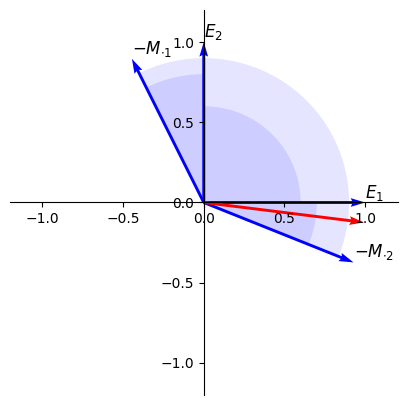

In [8]:
ex_lcp = LCP(M_i_j = np.array([[5, -10], [-10, 4]]), 
             q_i = np.array([8, -1]))
ex_lcp.qp_solve(verbose=1)
ex_lcp.plot_cones()

Here the vector $q$ lies in two of the cones, and therefore the LCP has a solution.  
We also see that if we decrease $q_1$ enough, the problem does not have a solution anymore.

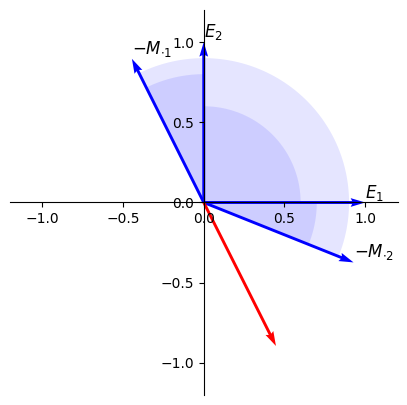

In [9]:
ex_lcp.q_i = np.array([1, -2])
#ex_lcp.qp_solve(verbose=1, silent=False)  # problem is not feasible
#ex_lcp.lemke_solve(verbose=2)    # ray termination
ex_lcp.plot_cones()

# Lemke algorithm

The Lemke algorithm works in a manner similar to the simplex algorithm: at each step, it chooses an entering variable, a departing variable, and performs a pivot operation to update the tableau accordingly.
Its specificity is that it always chooses the entering variable so as to maintain a property of the basis called *almost complementarity*.
Let's provide a quick description here.

---

*Lemke algorithm*

**Step 0.**
Introduce an artificial variable $z_0$ associated with the column vector $-1_n$.
Let $i^* = \arg\min_i q_i$, and choose the initial basic variables as $w_1, \dots, w_{i^* - 1}, z_0, w_{i^* + 1}, \dots, w_n$.
Update the tableau.

**Step 1.** Choose the entering variable as the complement of the last departing variable.
(Right after step 0, this is $z_{i^*}$.)

**Step 2.**
Determine the departing variable using the minimum-ratio rule in the current tableau.
If there is no admissible departing variable, stop (this is called *ray termination*).

**Step 3.**
Update the tableau.
If the departing variable is $z_0$, stop and find the solution.
If not, go back to step 1.

---

**Step 0. Finding an initial basic feasible vector**

We saw that the case $q \geq 0$ is trivial, and therefore we will assume that there is at least one $q_i < 0$.
For this reason, we cannot take $w_i = q_i$, $z_i = 0$ as our initial basic feasible vector.

Instead, we introduce an artificial variable $z_0 \geq 0$ associated with the column vector $-1_n = ( -1, \dots, -1)^\top$, yielding the system 

\begin{equation}
    w - M z - z_0 1_n = q.
\end{equation}

Denoting $i^* = \arg\min_i q_i$, we can then choose the initial basic feasible vector

\begin{align}
    z_0 &= -q_{i^*} & ~ \\
    z_i &= 0 &(\forall i \geq 1) \\
    w_i &= q_i - q_{i^*} &(\forall i \neq i^*) \\
    w_{i^*} &= 0, & ~
\end{align}

and our initial basic variables are $w_1, \dots, w_{i^* - 1}, z_0, w_{i^* + 1}, \dots, w_n$.

We say that this basis is *almost complementary*, because it contains exactly one variable from each complementary pair $(z_i, w_i)$, except for one, namely $(z_{i^*}, w_{i^*})$.
This is a property of the basis that we want to maintain throughout: for this reason, we choose $z_{i^*}$ as the first entering variable.

By maintaining almost complementarity of the basis, if at some point $z_0$ is chosen as the departing variable, our basis will become *complementary*, and we will have found a solution to the LCP.


We will make use of the class `Tableau` from the linear programming lectures to implement the algorithm.
We start with a method to create the tableau associated with a LCP, including the artificial variable $z_0$.

In [10]:
from mec.lp import Tableau

def LCP_create_tableau(self, display=False):
    tab = Tableau(A_i_j = -np.block([self.M_i_j, np.ones((self.nbi,1))]),
                  d_i = self.q_i, c_j = None,
                  decision_var_names_j=self.z_names_i+['z_0'], slack_var_names_i=self.w_names_i)
    self.tableau = tab
    if display: tab.display()

LCP.create_tableau = LCP_create_tableau

murty_ex_2_9.create_tableau(display=True)

+-----+-------+-------+-------+-------+-------+-------+-------+-------+
|     |   w_1 |   w_2 |   w_3 |   z_1 |   z_2 |   z_3 |   z_0 |   RHS |
+=====+=======+=======+=======+=======+=======+=======+=======+=======+
| Obj |     0 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_1 |     1 |     0 |     0 |    -1 |    -0 |    -3 |    -1 |    -3 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_2 |     0 |     1 |     0 |     1 |    -2 |    -5 |    -1 |    -2 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_3 |     0 |     0 |     1 |    -2 |    -1 |    -2 |    -1 |    -1 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+


We update the tableau according to our initial basis.

In [11]:
def LCP_initialize_basis(self, verbose=0, display=False):
    self.create_tableau()
    zis = self.tableau.decision_var_names_j
    wis = self.tableau.slack_var_names_i
    kent = 2*self.nbi # z_0 enters
    kdep = np.argmin(self.q_i) # w_istar departs
    if verbose>0: print((wis+zis)[kent] + ' enters, ' + (wis+zis)[kdep] + ' departs')
    self.tableau.update(kent, kdep)
    if display: self.tableau.display()
    return kdep

LCP.initialize_basis = LCP_initialize_basis

In [12]:
kdep = murty_ex_2_9.initialize_basis(verbose=1, display=True)

z_0 enters, w_1 departs
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
|     |   w_1 |   w_2 |   w_3 |   z_1 |   z_2 |   z_3 |   z_0 |   RHS |
+=====+=======+=======+=======+=======+=======+=======+=======+=======+
| Obj |     0 |     0 |     0 |     0 |     0 |     0 |     0 |     0 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| z_0 |    -1 |    -0 |    -0 |     1 |     0 |     3 |     1 |     3 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_2 |    -1 |     1 |     0 |     2 |    -2 |    -2 |     0 |     1 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_3 |    -1 |     0 |     1 |    -1 |    -1 |     1 |     0 |     2 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+


**Step 1. Entering variable**

In the Lemke algorithm, the entering variable is chosen so as to maintain an almost complementary basis.
With this rule, there is a single choice for the entering variable at each iteration.
For instance, since $w_{i^*}$ left the basis in step 0 (it was replaced by $z_0$), the next entering variable must be $z_{i^*}$.

In general, as long as $z_0$ still belongs to the basis, the last departing variable must have been some $w_{i^*}$ or $z_{i^*}$ ($i^* \neq 0$). Then, in order to maintain an almost complementary basis, our choice for the next entering variable must be $z_{i^\star}$ or $w_{i^\star}$, respectively.

In [13]:
complements = list(murty_ex_2_9.nbi+np.arange(murty_ex_2_9.nbi)) + list(np.arange(murty_ex_2_9.nbi))
kent = complements[kdep]

print((murty_ex_2_9.tableau.slack_var_names_i + murty_ex_2_9.tableau.decision_var_names_j)[kent], 'enters')

z_1 enters


**Step 2. Departing variable**

The departing variable is chosen according to the minimum ratio rule, similar to the simplex algorithm.

If there is no such departing variable (because the column vector associated with the entering variable has all  its entries nonnegative) then the algorithm stops without finding a solution.
This is called **ray termination**, because all values of the entering variable lead to a feasible vector, creating a half-line of feasible vectors (but which are not solutions to the LCP).

Importantly, ray termination can occur even if the LCP *has* a solution.
Here, additional assumptions on the matrix $M$ can ensure that the Lemke algorithm finds a solution if one exists.
We come back to this below.


The choice of a departing variable will be implemented using the method `determine_departing` from the `Tableau` class.

In [14]:
kdep = murty_ex_2_9.tableau.determine_departing(kent)

print((murty_ex_2_9.tableau.slack_var_names_i + murty_ex_2_9.tableau.decision_var_names_j)[kdep], 'departs')

w_2 departs


**Step 3: Pivot**

The tableau is updated using the `update` method from the `Tableau` class.

Here, one of two cases can arise:
1. *The departing variable was not $z_0$.* The algorithm proceeds normally, back to step 1.
2. *The departing variable was $z_0$.* Then our new basis is complementary, leading to a complementary basic feasible vector, i.e. a solution to the LCP that we recover using the `solution` method.

In [15]:
murty_ex_2_9.tableau.update(kent, kdep)
murty_ex_2_9.tableau.display()

+-----+-------+-------+-------+-------+-------+-------+-------+-------+
|     |   w_1 |   w_2 |   w_3 |   z_1 |   z_2 |   z_3 |   z_0 |   RHS |
+=====+=======+=======+=======+=======+=======+=======+=======+=======+
| Obj |   0   |   0   |     0 |     0 |     0 |     0 |     0 |   0   |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| z_0 |  -0.5 |  -0.5 |    -0 |     0 |     1 |     4 |     1 |   2.5 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| z_1 |  -0.5 |   0.5 |     0 |     1 |    -1 |    -1 |     0 |   0.5 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+
| w_3 |  -1.5 |   0.5 |     1 |     0 |    -2 |     0 |     0 |   2.5 |
+-----+-------+-------+-------+-------+-------+-------+-------+-------+


We are now ready to implement the algorithm using `lemke_solve`.

In [16]:
def LCP_lemke_solve(self, verbose=0, maxit=100):
    counter = 0
    if all(self.q_i >= 0):
        print('==========')
        print('Solution found: trivial LCP (q >= 0).')
        zsol, wsol = np.zeros(self.nbi), self.q_i
        return zsol, wsol
    kdep = self.initialize_basis(verbose=verbose-1)
    zis = self.tableau.decision_var_names_j
    wis = self.tableau.slack_var_names_i
    complements = list(self.nbi+np.arange(self.nbi)) + list(np.arange(self.nbi))
    while counter < maxit:
        counter += 1
        kent = complements[kdep]
        kdep = self.tableau.determine_departing(kent)
        if kdep is None:
            break
        self.tableau.update(kent, kdep)
        if verbose > 1:
            print('Basis: ', [(wis+zis)[i] for i in self.tableau.k_b])
            print((wis+zis)[kent], 'enters,', (wis+zis)[kdep], 'departs')
        if kdep == 2*self.nbi:
            break
    print('==========')
    if kdep == 2*self.nbi:
        print('Solution found: z_0 departed basis.')
        zsol, _, _ = self.tableau.solution()
        wsol = self.M_i_j @ zsol[:-1] + self.q_i
        if verbose > 0:
            print('Complementarity: z.w = ' + str(zsol[:-1] @ wsol))
            for i in range(self.nbi): print('z_'+str(i+1)+' = ' + str(zsol[i]))
            for i in range(self.nbi): print('w_'+str(i+1)+' = ' + str(wsol[i]))
        return zsol[:-1], wsol
    elif counter == maxit:
        print('Solution not found: maximum number of iterations (' + str(maxit) + ') reached.')
        return None
    else:
        print('Solution not found: Ray termination.')
        return None

LCP.lemke_solve = LCP_lemke_solve

In [17]:
murty_ex_2_9.lemke_solve(verbose=2)

z_0 enters, w_1 departs
Basis:  ['z_0', 'z_1', 'w_3']
z_1 enters, w_2 departs
Basis:  ['z_2', 'z_1', 'w_3']
z_2 enters, z_0 departs
Solution found: z_0 departed basis.
Complementarity: z.w = 0.0
z_1 = 3.0
z_2 = 2.5
z_3 = 0.0
w_1 = 0.0
w_2 = 0.0
w_3 = 7.5


(array([3. , 2.5, 0. ]), array([0. , 0. , 7.5]))

## More examples

In [18]:
murty_ex_2_10.lemke_solve(verbose=1)

Solution found: z_0 departed basis.
Complementarity: z.w = 0.0
z_1 = 8.0
z_2 = 0.0
z_3 = 0.0
w_1 = 0.0
w_2 = 4.0
w_3 = 2.0


(array([8., 0., 0.]), array([0., 4., 2.]))

In [19]:
kostreva_ex.lemke_solve()

Solution found: z_0 departed basis.


(array([0., 1., 0.]), array([4., 0., 0.]))

In [20]:
kostreva_ex2.lemke_solve(verbose=2, maxit=10) # cycles

z_0 enters, w_1 departs
Basis:  ['z_0', 'z_1', 'w_3']
z_1 enters, w_2 departs
Basis:  ['z_0', 'z_2', 'w_3']
z_2 enters, z_1 departs
Basis:  ['z_0', 'z_2', 'w_1']
w_1 enters, w_3 departs
Basis:  ['z_0', 'z_3', 'w_1']
z_3 enters, z_2 departs
Basis:  ['z_0', 'z_3', 'w_2']
w_2 enters, w_1 departs
Basis:  ['z_0', 'z_1', 'w_2']
z_1 enters, z_3 departs
Basis:  ['z_0', 'z_1', 'w_3']
w_3 enters, w_2 departs
Basis:  ['z_0', 'z_2', 'w_3']
z_2 enters, z_1 departs
Basis:  ['z_0', 'z_2', 'w_1']
w_1 enters, w_3 departs
Basis:  ['z_0', 'z_3', 'w_1']
z_3 enters, z_2 departs
Solution not found: maximum number of iterations (10) reached.


# Appendix

### Sufficient conditions for convergence

The Lemke algorithm always finds a solution (if it exists) when:
* the matrix $M$ is copositive plus,
* the matrix $M$ is an $L$-matrix,
* the matrix $M$ is positive-definite: $z^\top M z > 0$ for all $z \neq 0$
* the matrix $M$ is a P-matrix

**Copositive matrices.** $M$ is a copositive matrix iff $\forall z \geq 0, \; z^\top M z \geq 0$.

**Copositive plus matrices.** $M$ is a copositive plus matrix iff it is a copositive matrix and whenever $y \geq 0$  satisfies $y^\top M y = 0$ we have $y^\top (M + M^\top) = 0$.

**Theorem (Murty 2.1).** If $M$ is a copositive plus matrix and there is a feasible vector to the LCP $(M,q)$ (i.e. there exist $z, w \geq 0$ such that $w = Mz + q$), then this LCP has a solution and the Lemke algorithm terminates with a solution.  
(In particular when $M$ is strictly copositive, it always terminates with a solution.)



### LCPs and P-matrices

**Definition.** A square matrix $M$ is a P-matrix if it satisfies one of following equivalent properties.
* Every principal minor of $M$ is positive.  
* For any vector $z \neq 0$, there is a nonzero diagonal matrix $D_z$ with nonnegative coefficients such that $z^\top D_z M z > 0$.
* For any vector $z \neq 0$, there is an index $i$ such that $z_i \neq 0$ and $z_i (M z)_i > 0$.

Linear complementarity problems have a natural relationship with P-matrices, given by the following theorem.

---

**Theorem.** The linear complementarity problem $(M,q)$ has a unique solution for all vectors $q$ if and only if the matrix $M$ is a P-matrix.

*Proof.*  
Let's show that if $M$ is a P-matrix, then the LCP $(M,q)$ has at most one solution.  
Suppose that $z$ and $z'$ are both solutions. Then for all $i$, 

\begin{aligned}
(z - z')_i \big( M(z-z') \big)_i
&= (z - z')_i \big( (Mz + q) - (Mz' + q) \big)_i \\
&= z_i (Mz + q)_i - z_i (Mz' + q)_i - z'_i (Mz + q)_i + z'_i (Mz' + q)_i \\
&= - z_i (Mz' + q)_i - z'_i (Mz + q)_i \leq 0
\end{aligned}

since $z_i (Mz + q)_i = z'_i (Mz' + q)_i = 0$ and because of the positivity constraints of the LCP.  
Finally, since $M$ is a P-matrix, the inequality above implies that we must have $z - z' = 0$, i.e. $z = z'$.

To do: existence, reverse implication.

---

In particular, it means that if $M$ is *not* a P-matrix, then there exists $q$ such that either:
1. the LCP $(M,q)$ has no solution, or
2. the LCP $(M,q)$ has more than one solution.

*Note: can the proof somehow apply to the case where the matrix is non-reversing?*